In [ ]:
!pip install openai==0.28
!pip install Levenshtein #Evaluation
# !pip install nltk                         # already done

In [ ]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import sys

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance
from sklearn.preprocessing import LabelEncoder


# DATA COLLECTION


In [ ]:
# UPLOAD THE CORRECT ANSWERS CSV

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# file_path = "/content/drive/My Drive/DBSE Project/correct_answers.csv"
file_path = "/content/drive/My Drive/DBSE_Data/correct_answers.csv"

corrans_df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
# UPLOAD AND HANDLE THE INPUT DATA

warnings.filterwarnings("ignore")

def load_and_append_csv_files(directory_path):
    # Get a list of all CSV files in the specified directory
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # Check if there are any CSV files in the directory
    if not csv_files:
        print("No CSV files found in the specified directory.")
        return None

    dataframes = []  # List to store individual DataFrames

    # Loop through each CSV file and add it to the dataframes list
    for file_name in csv_files:
        file_path = os.path.join(directory_path, file_name)
        try:
            # Read the CSV file
            df = pd.read_csv(file_path, encoding='unicode_escape', sep='|', quoting=3, on_bad_lines='skip')
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not dataframes:
        return None

    # Combine all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True, sort=False)
    return combined_df

# Ask the user to input the directory path
directory_path = input("Enter the path to the directory containing CSV files: ")

# Check if the provided path is valid
if not os.path.exists(directory_path):
    print("Invalid directory path. Please provide a valid path.")
else:
    # Load and concatenate CSV files
    df = load_and_append_csv_files(directory_path)

    if df is not None:
        df['UserQuery'] = df['UserQuery'].str.strip('"').str.rstrip(';')
        df = df.filter(regex='^(?!.*timestamp).*$')
        df = df.drop_duplicates('UserQuery', keep='last').reset_index(drop=True)

        try:
            df['ID'] = df['ID'].astype(str)
            df['ID'] = df['ID'].str.strip('"')
            df['ID'] = df['ID'].astype(int)
        except: pass

        # /content/drive/My Drive/DBSE Project/Test_Data3/
        # /content/drive/My Drive/DBSE_Data/Test_Data3/

Enter the path to the directory containing CSV files: /content/drive/My Drive/DBSE_Data/Test_Data3/


In [ ]:
df_copy = df.copy() # Create a copy for testing purposes

df.columns.values[0] = 'ID'
df.describe()

,ID,UserID,taskid
count,3369.000000,3369.000000,3369.000000
mean,22373.123182,1190.770852,483.025230
std,26553.821148,69.269284,7.198922
min,230.000000,1101.000000,467.000000
25%,10980.000000,1143.000000,478.000000
50%,16239.000000,1185.000000,487.000000
75%,21799.000000,1223.000000,489.000000
max,197683.000000,1578.000000,489.000000


# DATA PREPROCESSING

In [ ]:
# REMOVE DUPLICATE/SIMILAR QUERIES
def remove_similar_queries(df):

    df_2 = df.copy()
    col_list = list(df.columns)

    # Tokenize sentences and compute cosine similarity
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['UserQuery'])

    # Compute cosine similarity
    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
    # Set "ID" as the index
    df.set_index('ID', inplace=True)

    # Create a DataFrame with "ID" as the first column
    similarity_df = pd.DataFrame(cosine_similarities, columns=df.index)

    # Get the column names of similarity_df
    similarity_columns = similarity_df.columns

    # Create a new DataFrame with a single column named "ID"
    id_df = pd.DataFrame({"ID": similarity_columns})

    # Concatenate the two DataFrames along columns
    result_df = pd.concat([id_df, similarity_df], axis=1)

    # Find values > 0.8 and < 1
    result_list = []
    for col in result_df.columns[1:]:
        filtered_values = result_df[(result_df[col] > 0.8) & (result_df[col] < 1)][['ID']]
        if not filtered_values.empty:
            result_list.extend(list(zip(filtered_values['ID'], [col] * len(filtered_values))))

    # Remove duplicates
    unique_tuples = set(tuple(sorted(t)) for t in result_list if t[0] != t[1])

    # Resulting list of tuples with duplicates removed
    result_list = list(unique_tuples)

    # Extract the smaller value from each tuple
    smaller_values = [min(t) for t in result_list]
    smaller_values = list(set(smaller_values))

    # Remove rows with IDs in the list
    df_filtered = df_2[~df_2['ID'].isin(smaller_values)]
    df_filtered.reset_index(drop=True,inplace=True)

    if df_filtered.empty:
      df_filtered = pd.DataFrame(columns=col_list)

    return df_filtered

# CALCULATE AVERAGE STUDENT ATTEMPTS
def calc_avg_attempts_per_student(df1):
    df2 = df1.drop_duplicates(subset=['UserID', 'taskid'], keep='first')
    avg_attempts_per_student = df2['student_attempt_per_task'].mean()
    df1['avg_attempts_per_student'] = math.ceil(avg_attempts_per_student)
    return df1

# SEGREGATE QUERIES BY COMMAND CATEGORIES
def segregate_categories(query):
    if pd.isnull(query):
        return 'Unknown'

    query = query.strip().lower().strip("'")

    if query.startswith(('select', 'with')):
        return 'DQL'
    elif query.startswith(('insert', 'update', 'delete', 'merge')):
        return 'DML'
    elif query.startswith(('create', 'alter', 'drop', 'truncate')):
        return 'DDL'
    elif query.startswith(('grant', 'revoke')):
        return 'DCL'
    else:
        return 'Unknown'

# df = df_copy.copy()

In [ ]:
# Count the number of unique task IDs for each UserID
unique_task_counts = df.groupby('UserID')['taskid'].nunique().reset_index()

# Rename the column to 'Unique_Tasks'
unique_task_counts = unique_task_counts.rename(columns={'taskid': 'Unique_Tasks'})

# Merge the original DataFrame with the counts based on UserID
df = pd.merge(df, unique_task_counts, on='UserID', how='left')

df = df.dropna(subset=['UserQuery']).reset_index(drop=True)

#Calculate maximum number of tasks
max_no_tasks = df['Unique_Tasks'].max()

# Set criteria for eligibility at 60% / 75% of tasks attemtped
eligible_students = math.floor(0.75 * max_no_tasks)

df = df[df.Unique_Tasks >= eligible_students]

# Group by 'UserID', 'taskid', and 'errorClasses', apply the function, and concatenate the results
df = df.groupby(['UserID', 'taskid', 'errorClasses']).apply(remove_similar_queries).reset_index(drop=True)

# Group by 'UserID' and 'TaskID', and count the occurrences
grouped_df = df.groupby(['UserID', 'taskid']).size().reset_index(name='student_attempt_per_task')

# Merge the original DataFrame with the grouped DataFrame on 'UserID' and 'TaskID'
df = pd.merge(df, grouped_df, on=['UserID', 'taskid'], how='left')
df['avg_attempts_per_student'] = ''
df = df.groupby(['UserID']).apply(calc_avg_attempts_per_student).reset_index(drop=True)


In [ ]:
# INTEGRATE CORRECT ANSWERS AND SELECT QUERIES MOST DISSIMILAR TO THE CORRECT ANSWER.

corrans_df.columns.values[0] = 'taskid'
mapped_df = pd.merge(df, corrans_df, on='taskid', how='inner')

# Define a function to calculate similarity
def calculate_similarity(row):
    user_query = row['UserQuery']
    answer_query = row['AnswerQuery']

    tfidf_vectorizer = TfidfVectorizer()

    tfidf_matrix = tfidf_vectorizer.fit_transform([user_query, answer_query]) # Fit and transfor

    similarity = cosine_similarity(tfidf_matrix)[0][1] # cosine similarity between user_query and answer_query

    return similarity

mapped_df['similarity'] = mapped_df.apply(calculate_similarity, axis=1) # Apply function

df = mapped_df.groupby(['UserID', 'taskid']).apply(lambda x: x.nsmallest(5, 'similarity')).reset_index(drop=True) # filter lowest 5 similarity queries

# Modify Error Class to be only 0 (Syntax Error) or 2 (Logical Error)
df['ErrorClass'] = df['errorClasses'].apply(lambda x: '2' if x != '0' else x)
df.drop('errorClasses', axis=1, inplace=True)

# Applying command category function
df['Commands_Cat'] = df['AnswerQuery'].apply(segregate_categories)

In [ ]:
# GROUPING QUERIES AND PRE-PROCESSING FOR SENDING TO LLM

# Group the UserQueries (which are more than 1 or 2) into Attempts column for every userid and taskid
student_attempts = df.groupby(['UserID', 'taskid'])['UserQuery'].apply(lambda x: x.tolist() if len(x) >= 2 else np.nan).reset_index(name='Attempts')

# Correct answer for each group
correct_answers = df[['UserID', 'taskid','AnswerQuery']]

df_new = df[['UserID', 'taskid', 'avg_attempts_per_student']]
df1 = df_new.drop_duplicates(subset=['UserID', 'taskid', 'avg_attempts_per_student'], keep='first')

# Merging of attempts and correct answers
merged_df = pd.merge(df1, student_attempts, on=['UserID', 'taskid'], how='left')
merged_df = pd.merge(merged_df, correct_answers, on=['UserID', 'taskid'], how='inner')

merged_df = merged_df.dropna(subset=['Attempts']).reset_index(drop=True)

merged_df['Attempts'] = merged_df['Attempts'].apply(tuple)

# Drop duplicates based on specified subset columns
merged_df = merged_df.drop_duplicates(subset=['UserID', 'taskid', 'avg_attempts_per_student', 'Attempts', 'AnswerQuery']).reset_index(drop=True)

merged_df['Attempts'] = merged_df['Attempts'].apply(list)

# Limit data for test
merged_df = merged_df.iloc[0:200]

merged_df.head(20)


,UserID,taskid,avg_attempts_per_student,Attempts,AnswerQuery
0,1101,467,6,"[Select Pilot.employee_ID, Pilot.license, Pilo...",select * from pilot where not license='i' and ...
1,1101,478,6,"[select avg(salary), jobfrom Employeewhere , s...","select job, avg(all salary) as average_salary ..."
2,1101,486,6,"[delete from Producer,, ALTER TABLE Producer D...",drop table producer;
3,1101,489,6,"[create table STUDENT (Student ID, first name,...",create table students( student_id int not null...
4,1103,476,5,"[select type, count(type) from departure, sele...","select count(distinct serial_number,type) as a..."
5,1103,487,5,"[create table player( first_name varchar(20),...","create table player( name varchar(30), firstna..."
6,1103,489,5,"[select*from restaurant, select*from RESTAURAN...",create table students( student_id int not null...
7,1104,467,8,[SELECT employee_ID FROM Pilot WHERE license N...,select * from pilot where not license='i' and ...
8,1104,476,8,[ SELECT DISTINCT (COUNT(flight_label)) FROM ...,"select count(distinct serial_number,type) as a..."
9,1104,478,8,"[SELECT average (salary) FROM Employee, SELECT...","select job, avg(all salary) as average_salary ..."


In [ ]:
# DATA SEGREGATION INTO DML, DQL, DCL and DDL

df_original = merged_df.copy()

df_original['Command_Category'] = df_original['AnswerQuery'].apply(segregate_categories)

count_cat = df_original['Command_Category'].value_counts()
print("Total rows before data generation:", df_original['Command_Category'].count())
print(count_cat)

most_common_category = df_original.groupby('taskid')['Command_Category'].apply(lambda x: x.value_counts().idxmax()) # Group by taskid and find the most frequent SQL_category

df_original['Command_Category'] = df_original['taskid'].map(most_common_category) # for each taskid with the most frequent category

Total rows before data generation: 200
DQL    100
DDL     94
DML      6
Name: Command_Category, dtype: int64


# Data Genereation

In [ ]:
# INITIALIZING OPEN AI

import openai

openai.api_key = 'SECRET_KEY' # Private API key

# print(engines)
def generate_queries(prompt):
    model_name = "gpt-3.5-turbo-0125"

    # Make the API call
    response = openai.ChatCompletion.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=2000,
        n=1,  # Number of completions to generate
        stop=None,  # You can specify custom stopping criteria if needed
    )

    queries = [choice['message']['content'].strip() for choice in response['choices']]


    return queries

## Prompt Generation using queries

In [ ]:
# Generate new prompts

def generate_synthetic_data(chunk_df):
  chunk_df['NewPrompt'] = ""
  new_prompts = []
  for index, row in chunk_df.iterrows():
      avg_attempts_per_student = row['avg_attempts_per_student']

      attempts = row['Attempts']
      correct_answer = row['AnswerQuery']

      # Replace the student attempts and correct answer in the prompt
      prompt = f"Simulate a student's attempts to solve SQL questions. Below are attempts made by the student before reaching the correct answer:\n"
      for attempt in attempts:
          prompt += f"'{attempt}'\n"

      # NEW
      prompt += f"The correct answer is : '{correct_answer}'. \n Now generate {2*avg_attempts_per_student} complex SQL attempts, half with logical errors and half with syntax errors to simulate the student attempts. Strictly, do not provide any explanation. Strictly, provide the SQL attempts in the format: 'Logical Error attempts:' and 'Syntax Error Attempts:'."
      new_prompts.append(prompt)
      # Add the new prompt to the 'NewPrompt' column
      chunk_df.at[index, 'NewPrompt'] = prompt

  # Apply the generate_queries function to each row in the 'NewPrompt' column
  chunk_df['GeneratedQueries'] = chunk_df['NewPrompt'].apply(generate_queries)

  return chunk_df


In [ ]:
# # Generate new prompts

# # def generate_synthetic_data(chunk_df):
# merged_df['NewPrompt'] = ""
# new_prompts = []
# for index, row in merged_df.iterrows():
#     avg_attempts_per_student = row['avg_attempts_per_student']

#     attempts = row['Attempts']
#     correct_answer = row['AnswerQuery']

#     # Replace the student attempts and correct answer in the prompt
#     prompt = f"Simulate a student's attempts to solve SQL questions. Below are attempts made by the student before reaching the correct answer:\n"
#     for attempt in attempts:
#         prompt += f"'{attempt}'\n"

#     # NEW
#     prompt += f"The correct answer is : '{correct_answer}'. \n Now generate {2*avg_attempts_per_student} complex SQL attempts, half with logical errors and half with syntax errors to simulate the student attempts. Strictly, do not provide any explanation. Strictly, provide the SQL attempts in the format: 'Logical Error attempts:' and 'Syntax Error Attempts:'."
#     new_prompts.append(prompt)
#     # Add the new prompt to the 'NewPrompt' column
#     merged_df.at[index, 'NewPrompt'] = prompt

# # Apply the generate_queries function to each row in the 'NewPrompt' column
# merged_df['GeneratedQueries'] = merged_df['NewPrompt'].apply(generate_queries)

#   # return chunk_df


In [ ]:
# merged_df.to_csv('/content/merged_df.csv', index=False)
# from google.colab import files

# files.download('/content/merged_df.csv')

In [ ]:
# Splitting the DataFrame into 20 separate DataFrames, each with 10 rows
dfs = [merged_df.iloc[i:i+10] for i in range(0, 200, 10)]

# Adding the remaining rows to the 21st DataFrame
# dfs.append(merged_df.iloc[200:])

# Now, dfs is a list containing the 21 DataFrames
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20 = dfs

In [ ]:
new_chunk_df1 = generate_synthetic_data(df1)

In [ ]:
new_chunk_df2 = generate_synthetic_data(df2)

In [ ]:
new_chunk_df3 = generate_synthetic_data(df3)

In [ ]:
new_chunk_df4 = generate_synthetic_data(df4)

In [ ]:
new_chunk_df5 = generate_synthetic_data(df5)

In [ ]:
new_chunk_df6 = generate_synthetic_data(df6)

In [ ]:
new_chunk_df7 = generate_synthetic_data(df7)

In [ ]:
new_chunk_df8 = generate_synthetic_data(df8)

In [ ]:
new_chunk_df9 = generate_synthetic_data(df9)

In [ ]:
new_chunk_df10 = generate_synthetic_data(df10)

In [ ]:
new_chunk_df11 = generate_synthetic_data(df11)

In [ ]:
new_chunk_df12 = generate_synthetic_data(df12)

In [ ]:
new_chunk_df13 = generate_synthetic_data(df13)

In [ ]:
new_chunk_df14 = generate_synthetic_data(df14)

In [ ]:
new_chunk_df15 = generate_synthetic_data(df15)

In [ ]:
new_chunk_df16 = generate_synthetic_data(df16)

In [ ]:
new_chunk_df17 = generate_synthetic_data(df17)

In [ ]:
new_chunk_df18 = generate_synthetic_data(df18)

In [ ]:
new_chunk_df19 = generate_synthetic_data(df19)

In [ ]:
new_chunk_df20 = generate_synthetic_data(df20)

In [ ]:
final_concat_df = pd.concat(
    [new_chunk_df1, new_chunk_df2, new_chunk_df3, new_chunk_df4, new_chunk_df5,
     new_chunk_df6, new_chunk_df7, new_chunk_df8, new_chunk_df9, new_chunk_df10,
     new_chunk_df11, new_chunk_df12, new_chunk_df13, new_chunk_df14, new_chunk_df15,
     new_chunk_df16, new_chunk_df17, new_chunk_df18, new_chunk_df19, new_chunk_df20],
    ignore_index=True
)


In [ ]:
# # Main DataFrame to store results
# main_df = pd.DataFrame()

# # Process 10 rows at a time
# for start_row in range(0, len(merged_df), 10):
#     print("Starting Iteration")
#     # Select 10 rows
#     chunk_df = merged_df.iloc[start_row:start_row + 10]

#     try:
#       # Apply the function
#       new_chunk_df = generate_synthetic_data(chunk_df)
#       # new_chunk_df = my_function(chunk_df)
#       # Append the result to the main DataFrame
#       main_df = pd.concat([main_df, new_chunk_df], ignore_index=True)
#     except Exception as e:
#       print("Exiting after processing rows: ", len(main_df))
#       print("Error:", e)
#       break

# print(len(main_df))

In [ ]:
merged_df = final_concat_df.copy()

In [ ]:
merged_df.head(10)

,UserID,taskid,avg_attempts_per_student,Attempts,AnswerQuery,NewPrompt,GeneratedQueries
0,1101,467,6,"[Select Pilot.employee_ID, Pilot.license, Pilo...",select * from pilot where not license='i' and ...,Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. Select employee_I...
1,1101,478,6,"[select avg(salary), jobfrom Employeewhere , s...","select job, avg(all salary) as average_salary ...",Simulate a student's attempts to solve SQL que...,"[Logical Error attempts:\n1. select job, avg(s..."
2,1101,486,6,"[delete from Producer,, ALTER TABLE Producer D...",drop table producer;,Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. SELECT * from Cus...
3,1101,489,6,"[create table STUDENT (Student ID, first name,...",create table students( student_id int not null...,Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. 'create table stu...
4,1103,476,5,"[select type, count(type) from departure, sele...","select count(distinct serial_number,type) as a...",Simulate a student's attempts to solve SQL que...,"[Logical Error attempts:\n1. select type, coun..."
5,1103,487,5,"[create table player( first_name varchar(20),...","create table player( name varchar(30), firstna...",Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. 'create table pla...
6,1103,489,5,"[select*from restaurant, select*from RESTAURAN...",create table students( student_id int not null...,Simulate a student's attempts to solve SQL que...,[Logical Error attempts: \n1. SELECT COUNT(*) ...
7,1104,467,8,[SELECT employee_ID FROM Pilot WHERE license N...,select * from pilot where not license='i' and ...,Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. SELECT employee_I...
8,1104,476,8,[ SELECT DISTINCT (COUNT(flight_label)) FROM ...,"select count(distinct serial_number,type) as a...",Simulate a student's attempts to solve SQL que...,[Logical Error attempts:\n1. SELECT COUNT(seri...
9,1104,478,8,"[SELECT average (salary) FROM Employee, SELECT...","select job, avg(all salary) as average_salary ...",Simulate a student's attempts to solve SQL que...,"[Logical Error Attempts:\n1. SELECT job, salar..."


In [ ]:
merged_df.to_csv('/content/merged_df.csv', index=False)
from google.colab import files

files.download('/content/merged_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Postprocessing generated data

In [ ]:
# CLEANING THE QUERIES GENERATED BY THE LLM

import re

def extract_queries(query_group, user_id, taskid, original_attempts):
    logical_queries = []
    syntax_queries = []
    user_ids = []
    taskids = []

    for i, query_list in enumerate(query_group):
        logical_queries_group = []
        syntax_queries_group = []

        user_id_group = user_id[i]
        taskid_group = taskid[i]

        for query in query_list:

            logical_matches = re.findall(r'Logical Error [a-zA-Z]*[aA]ttempts:(.*?)Syntax Error [a-zA-Z]*[aA]ttempts:', query, re.DOTALL)
            syntax_matches = re.findall(r'Syntax Error [a-zA-Z]*[aA]ttempts:(.*?)$', query, re.DOTALL)

            logical_matches = [re.sub(r'\n\d*\.?\s*', '', q) for q in logical_matches]
            syntax_matches = [re.sub(r'\n\d*\.?\s*', '', q) for q in syntax_matches]

            # Append matched queries to respective lists
            logical_queries_group.append(logical_matches)
            syntax_queries_group.append(syntax_matches)

        logical_queries.append(logical_queries_group)
        syntax_queries.append(syntax_queries_group)

        user_ids.append(user_id_group)
        taskids.append(taskid_group)

    result_dict = {
        'UserID': user_ids,
        'taskid': taskids,
        'Original Attempts': original_attempts,
        'Logical Error Attempts': logical_queries,
        'Syntax Error Attempts': syntax_queries,
    }

    return result_dict

user_id = merged_df['UserID'].tolist()
taskid = merged_df['taskid'].tolist()
query_group = merged_df['GeneratedQueries'].tolist()
original_attempts = merged_df['Attempts'].tolist()

result_dict= extract_queries(query_group, user_id, taskid, original_attempts)

result_df = pd.DataFrame(result_dict)
result_df.head()

,UserID,taskid,Original Attempts,Logical Error Attempts,Syntax Error Attempts
0,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","[[Select employee_ID, license from pilot where...","[[Select employee_ID, license from pilot where..."
1,1101,478,"[select avg(salary), jobfrom Employeewhere , s...","[[select job, avg(salary) as average_salary fr...",[[select job avg(salary) as average_salary fro...
2,1101,486,"[delete from Producer,, ALTER TABLE Producer D...",[[SELECT * from Customer WHERE City = 'New Yor...,[[SELET * FROM Inventory;UPDATE Employees SET ...
3,1101,489,"[create table STUDENT (Student ID, first name,...",[['create table students student_id int not nu...,[['create table students( student_id int not n...
4,1103,476,"[select type, count(type) from departure, sele...","[[select type, count(*) as amount from departu...",[[select count* distinct type as amount from d...


In [ ]:
# FURTHER CLEANING AND EXPANDING THE DATA

def expand_dataframe(row):
    rows = []
    for attempts_list, error_class in [(row['Logical Error Attempts'], 2), (row['Syntax Error Attempts'], 0)]:
        for item in attempts_list:
            for attempt in item:
                split_attempts = attempt.split(';')  # Split the attempt using the semicolon delimiter
                for split_attempt in split_attempts:
                    # Remove leading and trailing single or double quotes
                    split_attempt = split_attempt.strip(" '").strip(" `").strip('*')
                    rows.append({'UserID': row['UserID'], 'taskid': row['taskid'], 'Original Attempts': row['Original Attempts'], 'Combined_Attempts': split_attempt, 'ErrorClass': error_class})

    return rows

expanded_rows = []

for index, row in result_df.iterrows():
    expanded_rows.extend(expand_dataframe(row))

expanded_df = pd.DataFrame(expanded_rows)

expanded_df = expanded_df[expanded_df['Combined_Attempts'] != '**'] # remove output generated by the LLMs that is bold

# remove rows containing garbage
expanded_df = expanded_df[(expanded_df['Combined_Attempts'] != '') & (expanded_df['Combined_Attempts'].str.len() >= 4)]

expanded_df.head(20)

,UserID,taskid,Original Attempts,Combined_Attempts,ErrorClass
0,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where l...",2
1,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where l...",2
2,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...",Select * from pilot where license != 'I' or li...,2
3,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...",Select * from pilot where license='I' and lice...,2
4,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where n...",2
5,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...",Select * from pilot where license='I' or fligh...,2
7,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where n...",0
8,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where n...",0
9,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where n...",0
10,1101,467,"[Select Pilot.employee_ID, Pilot.license, Pilo...","Select employee_ID, license from pilot where n...",0


In [ ]:
# To check valuecounts for different classes for every userid, groupid

expanded_df['ErrorClass'] = expanded_df['ErrorClass'].astype('category')
errorclassdf = expanded_df.groupby(['UserID', 'taskid'])['ErrorClass'].value_counts()

print(errorclassdf)


UserID  taskid  ErrorClass
1101    467     2             6
                0             5
        478     0             5
                2             5
        486     0             6
                             ..
1222    478     2             4
        487     0             4
                2             4
        489     0             4
                2             4
Name: ErrorClass, Length: 400, dtype: int64


In [ ]:
# APPLYING SEGREGATION TO THE GENERATED DATA

generated_df = expanded_df.copy()

### Segregation on the df_categories
generated_df['Command_Category'] = generated_df['Combined_Attempts'].apply(segregate_categories)

# Group by taskid and find the most frequent SQL_category
most_common_category = generated_df.groupby('taskid')['Command_Category'].apply(lambda x: x.value_counts().idxmax())

generated_df['Command_Category'] = generated_df['taskid'].map(most_common_category) # most frequent category

count_cat = generated_df['Command_Category'].value_counts()
print(count_cat)

DQL    813
DDL    611
DML    125
Name: Command_Category, dtype: int64


In [ ]:
generated_df.to_csv('/content/synthetic_data_gpt_3_5.csv', index=False)
from google.colab import files
files.download('/content/synthetic_data_gpt_3_5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
generated_df_copy = generated_df.copy()

# Evaluation

In [ ]:
def calculate_cosine_similarity(text_list_1, text_list_2):
    combined_texts = text_list_1 + text_list_2

    vectorizer = CountVectorizer(token_pattern=r'\b\w+\b') #Initialize CountVectorizer for SQL
    vectorized_texts = vectorizer.fit_transform(combined_texts)

    vectors_1 = vectorized_texts[:len(text_list_1)]
    vectors_2 = vectorized_texts[len(text_list_1):]

    similarity_matrix = cosine_similarity(vectors_2, vectors_1)

    return similarity_matrix

def jaccard_similarity(query1, query2):
    set1 = set(query1.split())
    set2 = set(query2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def aligon_similarity(query1, query2):
    intersection = len(set(query1) & set(query2))
    return intersection / max(len(query1), len(query2))

def aouiche_similarity(query1, query2):
    common = len(set(query1) & set(query2))
    return common / (len(query1) + len(query2) - common)

def makiyama_similarity(query1, query2):
    query1_length = len(query1.split())
    query2_length = len(query2.split())
    if query1_length == 0 or query2_length == 0:
        return 0
    else:
        return (2.0 * np.minimum(query1_length, query2_length)) / (query1_length + query2_length)

def calculate_similarity_matrix(original_q, generated_q, similarity_function):
    num_queries_1 = len(original_q)
    num_queries_2 = len(generated_q)
    similarity_matrix = np.zeros((num_queries_1, num_queries_2))
    for i in range(num_queries_1):
        for j in range(num_queries_2):
            similarity = similarity_function(original_q[i], generated_q[j])
            similarity_matrix[i][j] = similarity
    return similarity_matrix

In [ ]:
# COSINE SIMILARITY CALCULATION

originalv_df = df.groupby(['UserID', 'taskid'])
gener_df = generated_df.groupby(['UserID', 'taskid'])

# Initialize an empty list to store results
average_similarity_results = []
all_similarity_results = []
all_command_categories = []
command_categories = []

# iterate over groups of userid, taskid
for (UserID, taskid), group_df2 in gener_df: # generated df
    group_df1 = originalv_df.get_group((UserID, taskid)) # original df

    text_list_1 = group_df1['UserQuery'].tolist() # original df
    text_list_2 = group_df2['Combined_Attempts'].tolist() # generated df

    # attempt to cluster DDL DQL DML and extract a new df with just clusters and errorclass in next code cell
    orig_command_cats = group_df1['Commands_Cat'].tolist()
    generated_command_cats = group_df2['Command_Category'].tolist()
    orig_errorclass = group_df1['ErrorClass'].tolist()
    generated_errorclass = group_df2['ErrorClass'].tolist()


    # jaccard_similarity_matrix = calculate_jaccard_similarity(text_list_1, text_list_2) # jaccard similarity
    cosine_similarity_matrix = calculate_cosine_similarity(text_list_1, text_list_2) # cosine
    jaccard = calculate_similarity_matrix(text_list_1, text_list_2, jaccard_similarity) # jaccard
    aligon = calculate_similarity_matrix(text_list_1, text_list_2, aligon_similarity) # aligon
    aouiche = calculate_similarity_matrix(text_list_1, text_list_2, aouiche_similarity) # aouiche
    makiyama = calculate_similarity_matrix(text_list_1, text_list_2, makiyama_similarity) # makiyama

    average_similarity = np.mean(cosine_similarity_matrix)
    avg_jaccard = np.mean(jaccard)
    avg_aligon = np.mean(aligon)
    avg_aouiche = np.mean(aouiche)
    avg_makiyama = np.mean(aouiche)


    average_similarity = np.mean(cosine_similarity_matrix) # mean for average cosine similarity
    # jacc_avg = np.mean(jaccard_similarity_matrix) # mean for jaccard

    if average_similarity >= 0.65: # also had to do this
        average_similarity_results.append({
            'UserID': UserID,
            'taskid': taskid,
            'cosine_similarity_matrix': average_similarity,
            'avg_aligon': avg_aligon,
            'avg_aouiche': avg_aouiche,
            'avg_makiyama': avg_makiyama,
            'avg_jaccard': avg_jaccard
        })

    command_categories.append({
        'UserID': UserID,
        'taskid': taskid,
        'original_commands': orig_command_cats,
        'generated_commands': generated_command_cats,
        'orig_errorclass': orig_errorclass,
        'generated_errorclass': generated_errorclass
      })

    all_command_categories.append({
        'UserID': UserID,
        'taskid': taskid,
        'original_commands': list(orig_command_cats),
        'generated_commands': list(generated_command_cats),
        'orig_errorclass': list(orig_errorclass),
        'generated_errorclass': list(generated_errorclass)
      })

    all_similarity_results.append({
            'UserID': UserID,
            'taskid': taskid,
            'cosine_similarity_matrix': average_similarity
            # 'jaccard_similarity': jacc_avg
        })

average_similarity_df = pd.DataFrame(average_similarity_results) # for calculating average total below

all_similarity_df = pd.DataFrame(all_similarity_results) # for calculating average total below

all_commands_df = pd.DataFrame(all_command_categories) # for other graphs

commands_df = pd.DataFrame(command_categories) # for other graphs

commands_df

,UserID,taskid,original_commands,generated_commands,orig_errorclass,generated_errorclass
0,1101,467,"[DQL, DQL, DQL]","[DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL, ...","[2, 0, 0]","[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]"
1,1101,478,"[DQL, DQL, DQL, DQL, DQL]","[DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL, ...","[0, 2, 0, 0, 0]","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0]"
2,1101,486,"[DDL, DDL, DDL]","[DML, DML, DML, DML, DML, DML, DML, DML, DML, ...","[0, 0, 2]","[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]"
3,1101,489,"[DDL, DDL, DDL, DDL, DDL]","[DDL, DDL, DDL, DDL, DDL, DDL, DDL, DDL, DDL, ...","[0, 0, 0, 2, 2]","[2, 2, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1103,476,"[DQL, DQL, DQL]","[DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL]","[2, 2, 0]","[2, 2, 2, 2, 2, 0, 0, 0, 0]"
...,...,...,...,...,...,...
195,1222,467,"[DQL, DQL, DQL, DQL, DQL]","[DQL, DQL]","[0, 2, 2, 0, 0]","[2, 0]"
196,1222,476,"[DQL, DQL]","[DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL]","[2, 0]","[2, 2, 2, 2, 0, 0, 0, 0]"
197,1222,478,"[DQL, DQL, DQL]","[DQL, DQL, DQL, DQL, DQL, DQL, DQL, DQL]","[0, 2, 0]","[2, 2, 2, 2, 0, 0, 0, 0]"
198,1222,487,"[DDL, DDL, DDL]","[DDL, DDL, DDL, DDL, DDL, DDL, DDL, DDL]","[2, 2, 0]","[2, 2, 2, 2, 0, 0, 0, 0]"


In [ ]:
average_similarity_df

,UserID,taskid,cosine_similarity_matrix,avg_aligon,avg_aouiche,avg_makiyama,avg_jaccard
0,1103,476,0.826185,0.286604,0.199568,0.199568,0.363139
1,1104,467,0.819177,0.362897,0.240570,0.240570,0.415139
2,1104,476,0.761928,0.411321,0.323564,0.323564,0.420233
3,1104,478,0.658904,0.377905,0.316632,0.316632,0.318880
4,1104,489,0.880583,0.150573,0.085102,0.085102,0.341001
...,...,...,...,...,...,...,...
84,1222,467,0.928899,0.108851,0.093245,0.093245,0.481877
85,1222,476,0.669221,0.395337,0.280843,0.280843,0.361883
86,1222,478,0.650418,0.421784,0.309258,0.309258,0.483531
87,1222,487,0.746766,0.113287,0.069663,0.069663,0.141440


In [ ]:
# CALCULATING AVERAGE COSINE SIMILARITY FOR DATASET

average_cosine_similarity = np.mean(average_similarity_df.cosine_similarity_matrix)
# average_jaccard_similarity = np.mean(average_similarity_df.jaccard_similarity)

print("Overall Cosine Similarity:", average_cosine_similarity)
# print("Overall Jaccard Similarity:", average_jaccard_similarity)

Overall Cosine Similarity: 0.7837091942867144


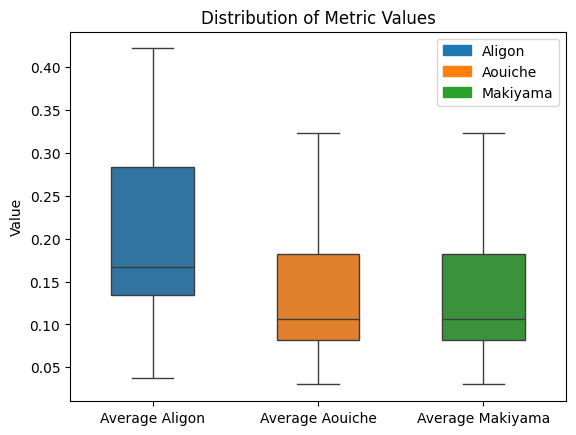

In [ ]:
# COMPARISON OF Aligon, Aouiche, Makiyama SIMILARITY METRICS

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
boxplot = sns.boxplot(data=average_similarity_df[['avg_aligon', 'avg_aouiche', 'avg_makiyama']], palette=colors, width=0.5)

plt.title('Distribution of Metric Values')
plt.ylabel('Value')
boxplot.set_xticklabels(['Average Aligon', 'Average Aouiche', 'Average Makiyama'])

legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ['Aligon', 'Aouiche', 'Makiyama'])]
plt.legend(handles=legend_patches, loc='upper right')

plt.show()

In [ ]:
# FURTHER POSTPROCESSING DATA

# Create separate dataframes for original commands and original df's error classes
orig_comm_class_df = pd.DataFrame(columns=['original_commands', 'orig_errorclass'])
for index, row in commands_df.iterrows():
    for command, error_class in zip(row['original_commands'], row['orig_errorclass']):
        orig_comm_class_df = orig_comm_class_df.append({'original_commands': command, 'orig_errorclass': error_class}, ignore_index=True)

# Create separate dataframes for generated commands and generated df's error classes
gen_comm_class_df = pd.DataFrame(columns=['generated_commands', 'generated_errorclass'])
for index, row in commands_df.iterrows():
    for command, error_class in zip(row['generated_commands'], row['generated_errorclass']):
        gen_comm_class_df = gen_comm_class_df.append({'generated_commands': command, 'generated_errorclass': error_class}, ignore_index=True)

# print("Original dataframe for original commands:")
gen_comm_class_df.head()

,generated_commands,generated_errorclass
0,DQL,2
1,DQL,2
2,DQL,2
3,DQL,2
4,DQL,2


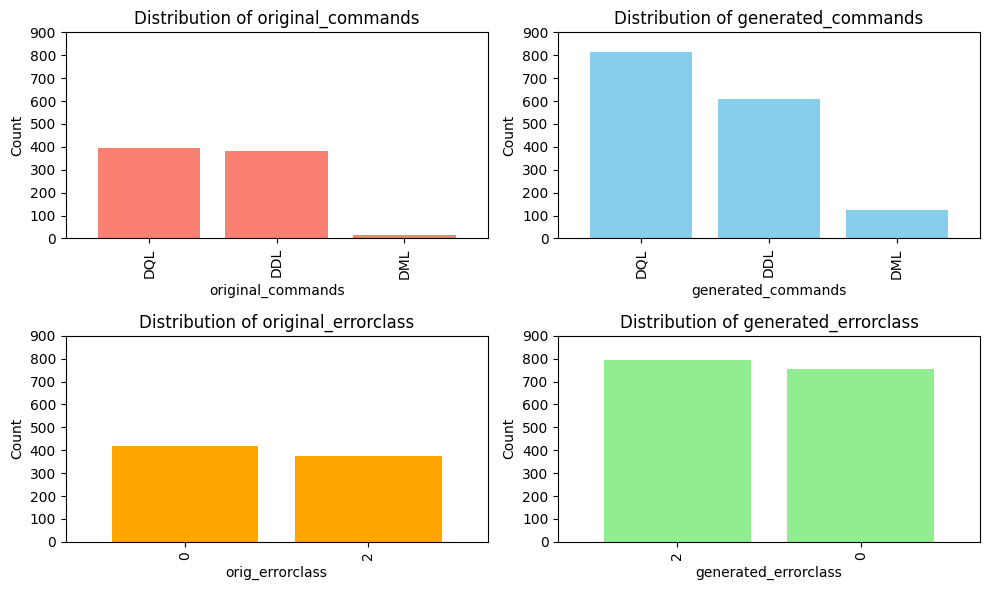

In [ ]:
# Create bar chart for original_commands
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
orig_comm_class_df['original_commands'].value_counts().plot(kind='bar', color='salmon', width=0.8)
plt.title('Distribution of original_commands')
plt.xlabel('original_commands')
plt.ylabel('Count')
plt.ylim(0, 250)
plt.yticks(range(0, 1000, 100))

# Create bar chart for generated_commands
plt.subplot(2, 2, 2)
gen_comm_class_df['generated_commands'].value_counts().plot(kind='bar', color='skyblue', width=0.8)
plt.title('Distribution of generated_commands')
plt.xlabel('generated_commands')
plt.ylabel('Count')
plt.ylim(0, 250)
plt.yticks(range(0, 1000, 100))

# Create bar chart for orig_errorclass
plt.subplot(2, 2, 3)
orig_comm_class_df['orig_errorclass'].value_counts().plot(kind='bar', color='orange', width=0.8)
plt.title('Distribution of original_errorclass')
plt.xlabel('orig_errorclass')
plt.ylabel('Count')
plt.ylim(0, 250)
plt.yticks(range(0, 1000, 100))

# Create bar chart for generated_errorclass
plt.subplot(2, 2, 4)
gen_comm_class_df['generated_errorclass'].value_counts().plot(kind='bar', color='lightgreen', width=0.8)
plt.title('Distribution of generated_errorclass')
plt.xlabel('generated_errorclass')
plt.ylabel('Count')
plt.ylim(0, 250)
plt.yticks(range(0, 1000, 100))

plt.tight_layout()
plt.show()

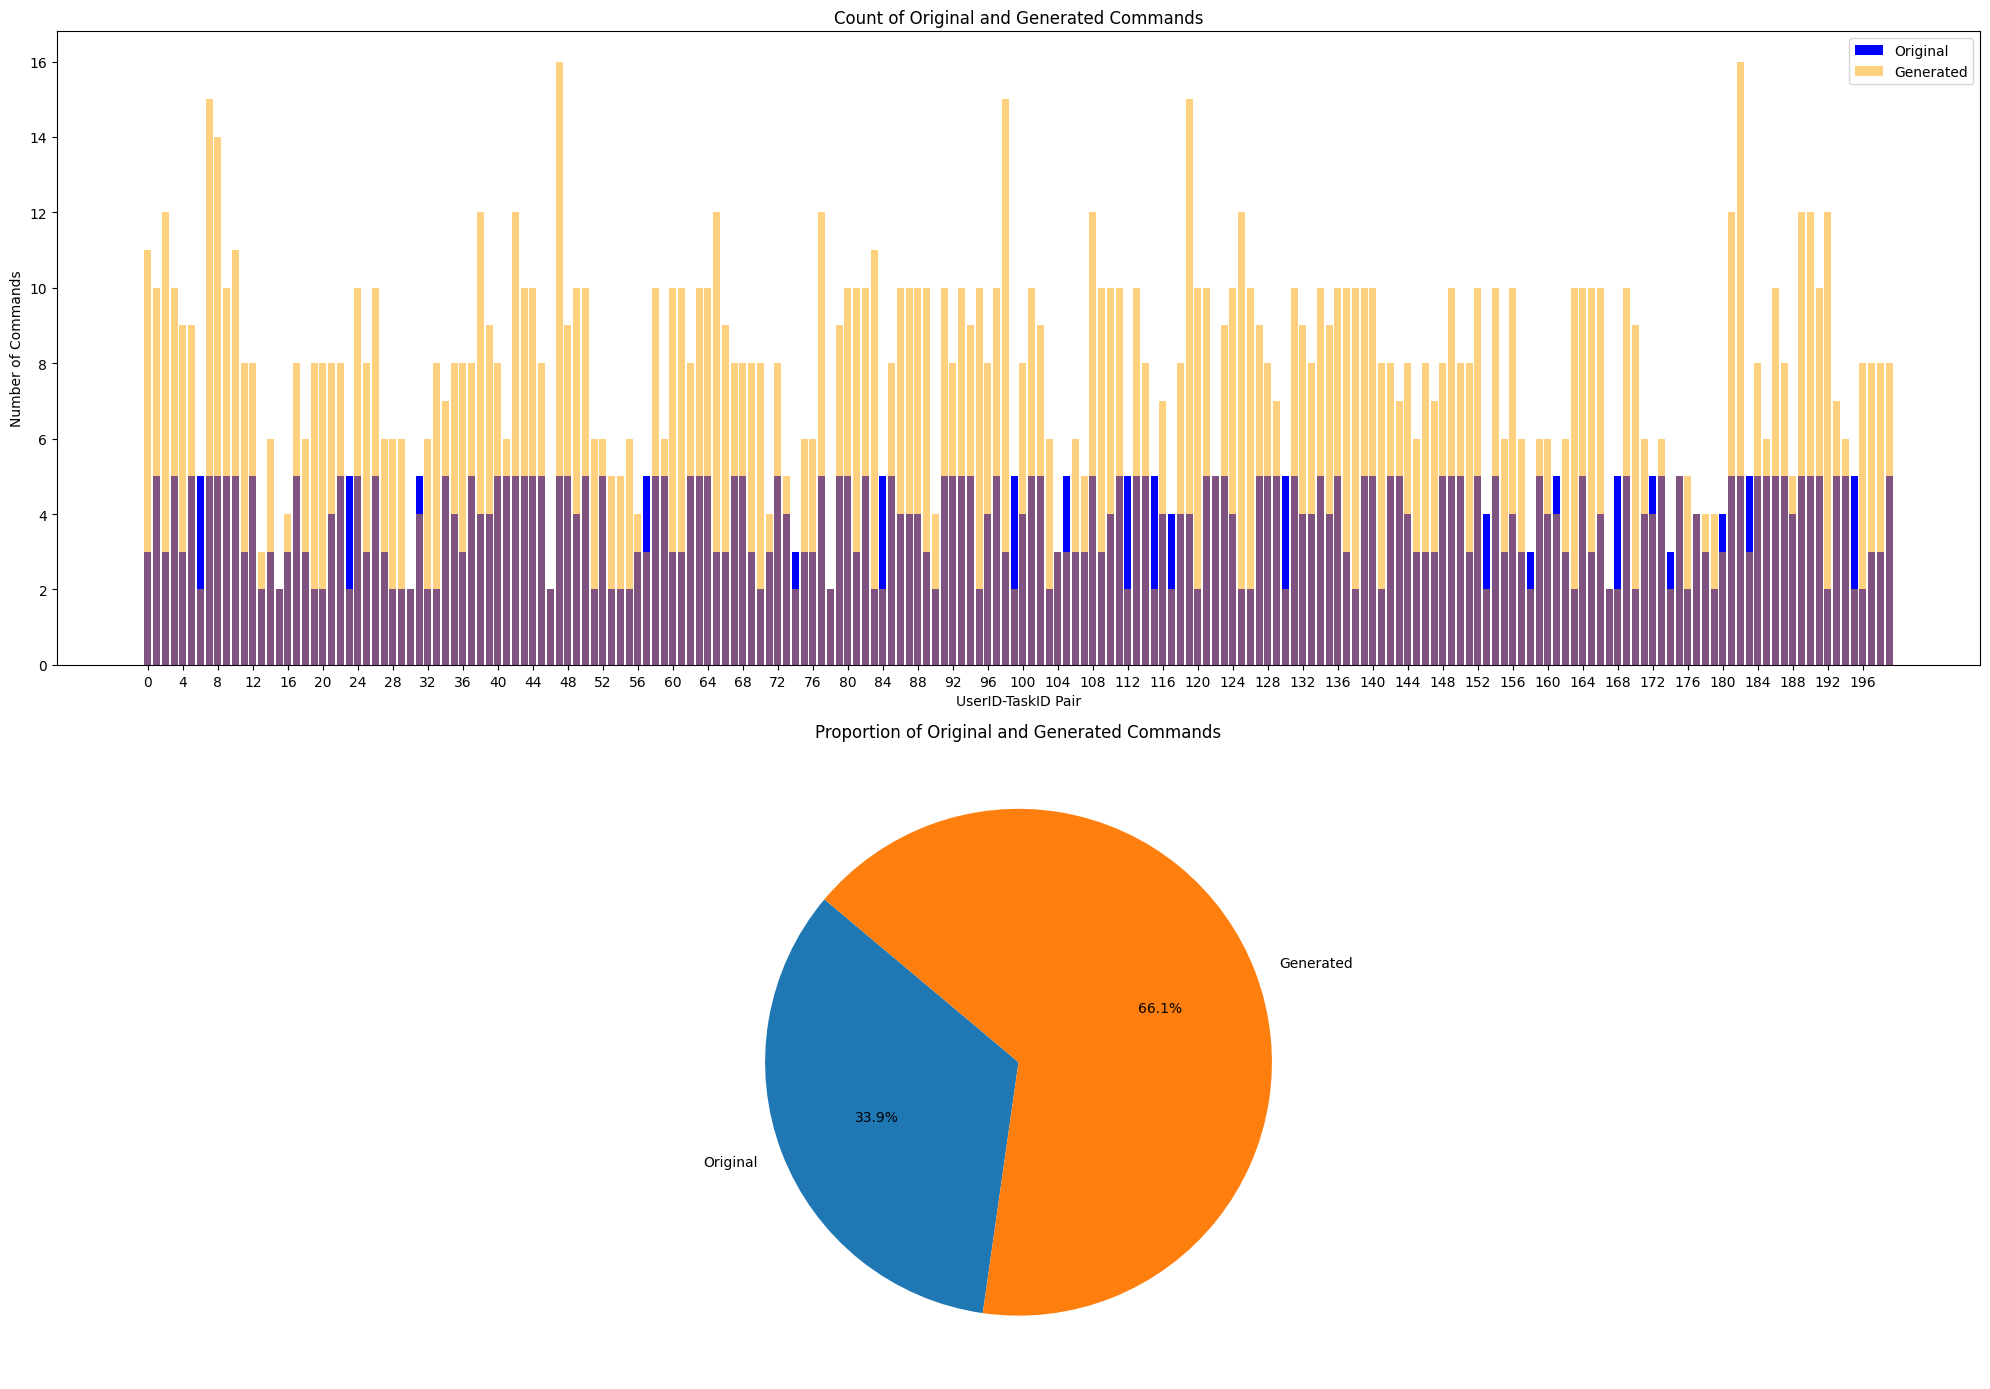

In [ ]:
# Count the number of original and generated commands for each UserID-taskid pair
commands_df['original_count'] = commands_df['original_commands'].apply(len)
commands_df['generated_count'] = commands_df['generated_commands'].apply(len)

# Plotting
plt.figure(figsize=(20, 14))

# Bar Plot
plt.subplot(2, 1, 1)
plt.bar(commands_df.index, commands_df['original_count'], color='blue', label='Original')
plt.bar(commands_df.index, commands_df['generated_count'], color='orange', label='Generated', alpha=0.5)
plt.xlabel('UserID-TaskID Pair')
plt.ylabel('Number of Commands')
plt.title('Count of Original and Generated Commands')
# plt.xticks(commands_df.index)
plt.xticks(commands_df.index[::4])
plt.legend()

# Pie Chart
plt.subplot(2, 1, 2)
plt.pie([commands_df['original_count'].sum(), commands_df['generated_count'].sum()], labels=['Original', 'Generated'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Original and Generated Commands')

plt.tight_layout()
plt.show()

In [ ]:
# Concatenate all original attempts into a single string for comparison
generated_df_copy['Original Attempts Combined'] = generated_df_copy['Original Attempts'].apply(lambda x: ' '.join(x))

# Vectorizing the text using CountVectorizer
count_vectorizer = CountVectorizer()

# Combine the text to fit the CountVectorizer
all_text = pd.concat([generated_df_copy['Original Attempts Combined'], generated_df_copy['Combined_Attempts']])
count_vectorizer.fit(all_text)

# Transforming the text into count vectors
original_vec = count_vectorizer.transform(generated_df_copy['Original Attempts Combined'])
combined_vec = count_vectorizer.transform(generated_df_copy['Combined_Attempts'])

# Calculating the cosine similarity between original and combined attempts
cosine_similarities = [cosine_similarity(combined_vec[i], original_vec[i])[0][0] for i in range(original_vec.shape[0])]

# Adding the cosine similarity to the dataframe
generated_df_copy['cosine_similarity'] = cosine_similarities

In [ ]:
scatter_df_error0_new = generated_df_copy[generated_df_copy.ErrorClass == 0]
scatter_df_error2_new = generated_df_copy[generated_df_copy.ErrorClass == 2]

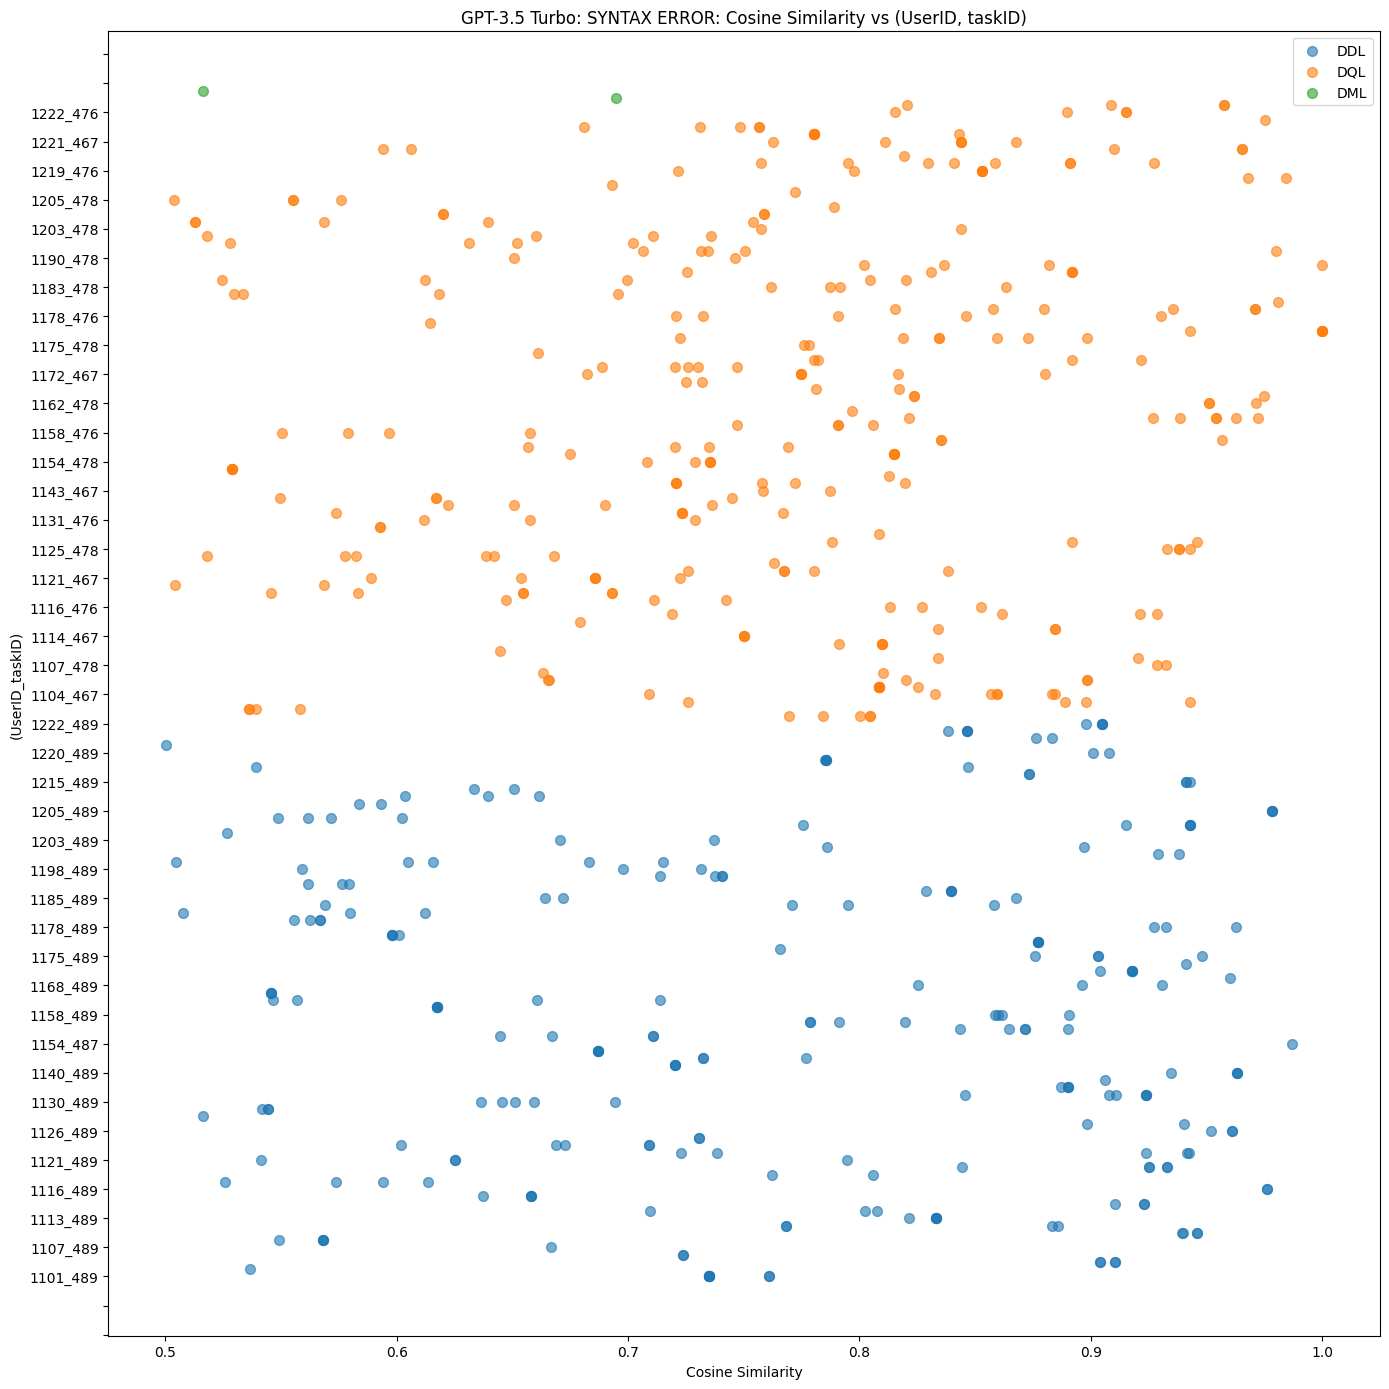

In [ ]:
scatter_df_error0_new = scatter_df_error0_new[scatter_df_error0_new.cosine_similarity >= 0.50]
scatter_df_error0_new['Attempt_ID'] = scatter_df_error0_new.apply(lambda row: (row['UserID'], row['taskid']), axis=1)
scatter_df_error0_new['Attempt_ID_str'] = scatter_df_error0_new['Attempt_ID'].apply(lambda x: f'{x[0]}_{x[1]}')

scatter_df_error0_new_ddl = scatter_df_error0_new[scatter_df_error0_new.Command_Category == 'DDL']
scatter_df_error0_new_dql = scatter_df_error0_new[scatter_df_error0_new.Command_Category == 'DQL']
scatter_df_error0_new_dml = scatter_df_error0_new[scatter_df_error0_new.Command_Category == 'DML']

scatter_df_error0_new_ddl = scatter_df_error0_new_ddl[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]
scatter_df_error0_new_dql = scatter_df_error0_new_dql[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]
scatter_df_error0_new_dml = scatter_df_error0_new_dml[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]

# Plot: Cosine similarity on x-axis and Attempt_ID on y-axis

plt.figure(figsize=(14, 14))
marker_size = 50

plt.scatter(scatter_df_error0_new_ddl['cosine_similarity'], scatter_df_error0_new_ddl['Attempt_ID_str'], label='DDL', alpha=0.6, s=marker_size)
plt.scatter(scatter_df_error0_new_dql['cosine_similarity'], scatter_df_error0_new_dql['Attempt_ID_str'], label='DQL', alpha=0.6, s=marker_size)
plt.scatter(scatter_df_error0_new_dml['cosine_similarity'], scatter_df_error0_new_dml['Attempt_ID_str'], label='DML', alpha=0.6, s=marker_size)

# Use MaxNLocator to control the maximum number of y-ticks
import matplotlib.ticker as ticker
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=50))  # Adjust 'nbins' as needed
# plt.gca().tick_params(axis='y', which='major', labelsize=8)

plt.yticks(rotation=0)

plt.xlabel('Cosine Similarity')
plt.ylabel('(UserID_taskID)')
plt.title('GPT-3.5 Turbo: SYNTAX ERROR: Cosine Similarity vs (UserID, taskID)')
plt.legend()
plt.tight_layout()
plt.show()

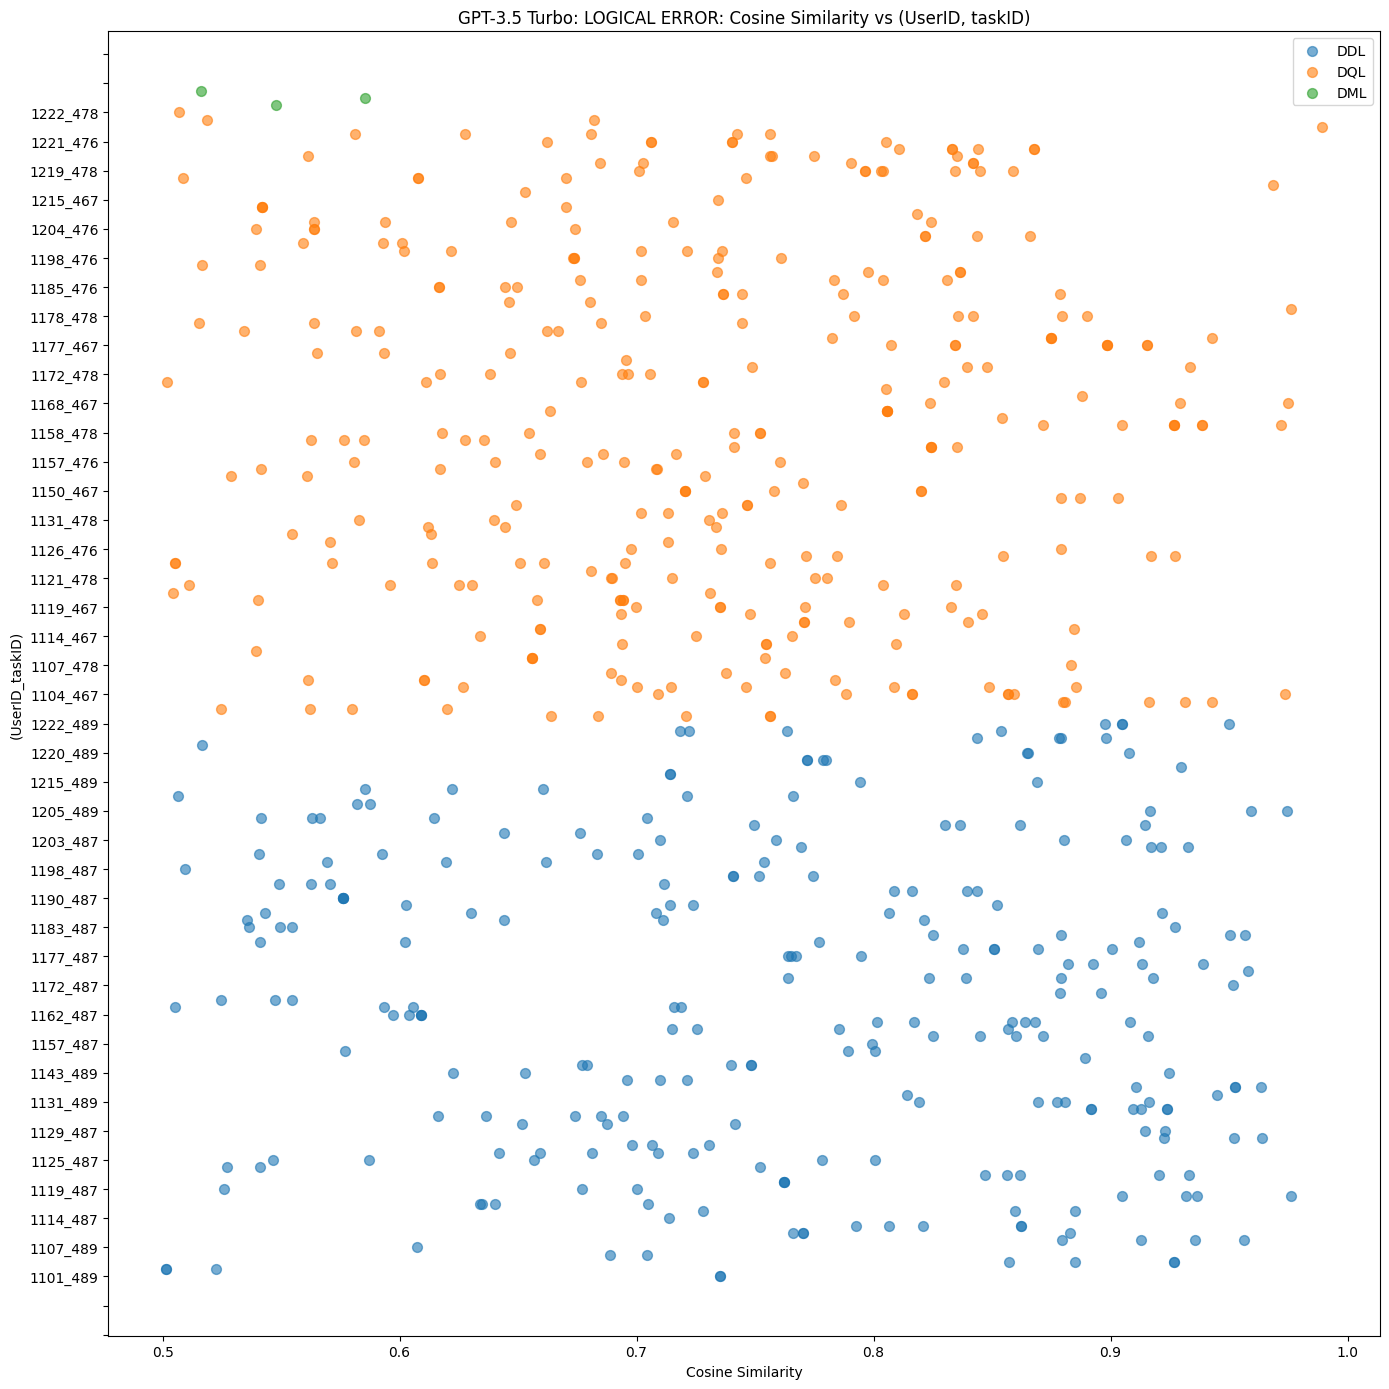

In [ ]:
scatter_df_error2_new = scatter_df_error2_new[scatter_df_error2_new.cosine_similarity >= 0.5]
scatter_df_error2_new['Attempt_ID'] = scatter_df_error2_new.apply(lambda row: (row['UserID'], row['taskid']), axis=1)
scatter_df_error2_new['Attempt_ID_str'] = scatter_df_error2_new['Attempt_ID'].apply(lambda x: f'{x[0]}_{x[1]}')

scatter_df_error2_new_ddl = scatter_df_error2_new[scatter_df_error2_new.Command_Category == 'DDL']
scatter_df_error2_new_dql = scatter_df_error2_new[scatter_df_error2_new.Command_Category == 'DQL']
scatter_df_error2_new_dml = scatter_df_error2_new[scatter_df_error2_new.Command_Category == 'DML']

scatter_df_error2_new_ddl = scatter_df_error2_new_ddl[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]
scatter_df_error2_new_dql = scatter_df_error2_new_dql[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]
scatter_df_error2_new_dml = scatter_df_error2_new_dml[['UserID', 'taskid', 'ErrorClass', 'Command_Category', 'cosine_similarity', 'Attempt_ID', 'Attempt_ID_str']]

# Plot: Cosine similarity on x-axis and Attempt_ID on y-axis

plt.figure(figsize=(14, 14))
marker_size = 50

plt.scatter(scatter_df_error2_new_ddl['cosine_similarity'], scatter_df_error2_new_ddl['Attempt_ID_str'], label='DDL', alpha=0.6, s=marker_size)
plt.scatter(scatter_df_error2_new_dql['cosine_similarity'], scatter_df_error2_new_dql['Attempt_ID_str'], label='DQL', alpha=0.6, s=marker_size)
plt.scatter(scatter_df_error2_new_dml['cosine_similarity'], scatter_df_error2_new_dml['Attempt_ID_str'], label='DML', alpha=0.6, s=marker_size)

# Use MaxNLocator to control the maximum number of y-ticks
import matplotlib.ticker as ticker
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=50))  # Adjust 'nbins' as needed
# plt.gca().tick_params(axis='y', which='major', labelsize=8)

plt.yticks(rotation=0)
plt.xlabel('Cosine Similarity')
plt.ylabel('(UserID_taskID)')
plt.title('GPT-3.5 Turbo: LOGICAL ERROR: Cosine Similarity vs (UserID, taskID)')
plt.legend()
plt.tight_layout()
plt.show()